# Stock Price Analysis

### Data Description

The original assignment was based on OCLHV data for NSE stocks with symbols INFY and TCS between 2015-2016 and on a Daily level. However, you can complete this project using any stock data you select. You can also choose other time periods.

### Assignment

**Part 1**:

- Create 4,16,....,52 week moving average(closing price) for each stock. This should happen through a function.

- Create a rolling window of size 10 on each stock. Handle unequal time series due to stock market holidays. You should look to increase your rolling window size to 75 and see what the data looks like. Remember they will create stress on your laptop RAM load. ( Documentation you might need: http://in.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html)

- Create the following dummy time series: 
    
    - 3.1 Volume shocks - If volume traded is 10% higher/lower than the previous day - make a 0/1 boolean time series for shock, 0/1 dummy-coded time series for the direction of shock. 
    
    - 3.2 Price shocks - If the closing price at T vs T+1 has a difference > 2%, then 0/1 boolean time series for shock, 0/1 dummy-coded time series for the direction of shock. 
    
    - 3.3 Pricing black swan - If the closing price at T vs T+1 has a difference > 2%, then 0/1 boolean time series for shock, 0/1 dummy-coded time series for the direction of shock. 
    
    - 3.4 Pricing shock without volume shock - based on points 3.1 & 3.2 - Make a 0/1 dummy time series.

**Part 2 (data visualization )**: For this section, you can use only bokeh.

- Create a time-series plot of close prices of stocks with the following features:

- Color the time series in simple blue color.

- Color time series between two volume shocks in a different color (Red)

- Gradient color in blue spectrum based on the difference of 52-week moving average.

- Mark closing Pricing shock without volume shock to identify volumeless price movement.

- Hand craft partial autocorrelation plot for each stock on up to all lookbacks on bokeh - sample reference - https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html

**Part 3 (data modeling)**:

- Quickly build any two models. The quick build is defined as a grid search of less than 9 permutation combinations. You can choose the two options of multiple multivariate models from those mentioned below. The goal is to predict INFY, and TCS prices for tomorrow. Models that you can choose:

    - LassoLars

    - Linear Regression

    - Ridge Regression

    - Support Vector Regression
    
    - Gradient Boosting Regression
    
    
- Write test cases for the two models you have chosen. Your testing should take at least 5-time steps except for today. your test cases must be written using pytest.

- Prove your model does not violate any basic assumption. To understand "model assumptions", read https://www.albert.io/blog/key-assumptions-of-ols-econometrics-review/

- Select the best performing model, and tune it - Demonstrate that your tuning has resulted in a clear difference between quick build and tuning.

- Extra credit - Nest a model to predict volume shock into your time series model - same conditions applied as above.

- Extra extra credit - Create a bare python file in the following fashion python stockpredictor.py ‘INFY’ should return prediction in less than 100 ms.

## Imports Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pathlib
import os

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler

import xgboost
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

2024-04-30 05:44:13.101098: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
from extra_files.aws_funcs import upload_to_s3

## USEFUL FUNCTION FOR THE PROJECT


#### Visualization

In [6]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    """
    Plots a timesteps  against values.
    Parameters
    ---------
    timesteps : array of timesteps
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot 
    end : where to end the plot 
    label : label to show on plot of values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def plot_loss_curves(history, metrics='mse'):
    # sourcery skip: extract-duplicate-method
    """
    Return separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history[metrics]
    val_accuracy = history.history[f'val_{metrics}']

    epochs = range(len(history.history['loss']))

    fig, ax = plt.subplots(1, 2, figsize=(15, 4), dpi=200)

    ax[0].plot(epochs, loss, label='training_loss')
    ax[0].plot(epochs, val_loss, label='val_loss')
    ax[0].set_title('loss')
    ax[0].set_xlabel('epochs')
    ax[0].legend()

    ax[1].plot(epochs, accuracy, label=f'training_{metrics}')
    ax[1].plot(epochs, val_accuracy, label=f'val_{metrics}')
    ax[1].set_title(metrics)
    ax[1].set_xlabel('epochs')
    ax[1].legend()

### Predictions

In [7]:
def make_preds(model, input_data):
    """
    Uses model to make predictions on input_data.

    Parameters
    ----------
    model: trained model 
    input_data: windowed input data (same kind of data model was trained on)

    Returns model predictions on input_data.
    """
    forecasts = model.predict(input_data)
    return tf.squeeze(forecasts)


def evaluate_preds(y_true, y_pred):
    """
    Evaluates prediction accuracy using various metrics for regression models.

    This function computes the mean absolute error (MAE), mean squared error (MSE), root mean squared error (RMSE), and mean 
    absolute percentage error (MAPE) between the true values and the predictions. It's useful for quantitatively assessing the 
    performance of regression models.

    Parameters:
    - y_true: The true values.
    - y_pred: The predicted values by the model.

    Returns:
    - A dictionary containing the computed metrics: MAE, MSE, RMSE, and MAPE, making it easier to understand the model's 
    performance across different error metrics.
    """

    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) 
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy()
            }

#### Sliding Window

In [8]:
def get_labelled_windows(x, horizon=1):
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size=7, horizon=1):
    """
    Generates sequences of windows and their corresponding labels from a time series dataset.

    This function takes a time series data array and creates overlapping windows of a specified size along with the labels 
    for each window. It's particularly useful for preparing data for time series forecasting models where you want to predict 
    a certain number of steps into the future based on a window of past observations.

    Parameters:
    - x (numpy.array): The time series data array from which to generate windows.
    - window_size (int, optional): The number of time steps in each window. Defaults to 7.
    - horizon (int, optional): The number of time steps into the future the label should be. Defaults to 1.

    Returns:
    - windows (numpy.array): The array of windows, each containing a sequence of data points from the time series.
    - labels (numpy.array): The array of labels corresponding to each window, indicating the future value(s) to be predicted.

    Note: This function assumes that 'get_labelled_windows' is a previously defined function that separates the generated 
    windowed array into features (windows) and targets (labels) based on the horizon.
    """

    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T 

    windowed_array = x[window_indexes]

    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

In [9]:
def make_windows_pandas(df, labels, features=None, window_size=7, horizon=1):
    """
    Transforms a DataFrame into a format suitable for windowed time series forecasting.
    It generates new features by shifting the specified columns backward according to 
    the window size and horizon, effectively creating lagged features. The function also 
    prepares target columns based on the specified labels.

    Parameters:
    - df (pd.DataFrame): The original DataFrame containing time series data.
    - labels (list of str): Column names in `df` that are to be used as targets.
    - features (list of str, optional): Column names to be used for generating features. 
      If None, all columns in `df` are used.
    - window_size (int, optional): The number of past observations to consider for each window.
    - horizon (int, optional): The number of steps ahead to forecast.

    Returns:
    - pd.DataFrame: A DataFrame containing the lagged features, with each column shifted 
      to create a window of observations.
    - pd.DataFrame: A DataFrame containing the target column(s) for the forecast horizon.
    """
    if features is None:
        features = []
    df_copy = df.copy()

    cols = features or df_copy.columns
    shifts = range(1, window_size + horizon)

    new_features = []
    for shift in shifts:
        for col in cols:
            df_copy[f'{col}_{shift}'] = df[col].shift(-shift)
            new_features.append(f'{col}_{shift}')

    new_features.extend(features)

    df_copy.dropna(inplace=True)

    df_copy.index = df_copy.index + pd.DateOffset(days=window_size + 2)

    target = pd.DataFrame()
    for label in labels:
        target[label] = df_copy[f'{label}_{window_size}']
        df_copy.drop(f'{label}_{window_size}', axis=1, inplace=True)

    df_copy.drop([col for col in df_copy.columns if col not in new_features], axis=1, inplace=True)

    return df_copy, target

#### AWS Uploader

In [10]:
path_to_local_plots = '/Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/images/'
path_local_images = 'data/images/'
def upload_to_aws_png(file_name):
    upload_to_s3(f'{path_to_local_plots}{file_name}.png', f'projects/Stock_Price_analysis/plots/{file_name}.png')

def upload(plot_name):
    plt.savefig(path_local_images + plot_name, dpi=300)
    upload_to_aws_png(plot_name)

In [11]:
path_to_local_csv = '/Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/csv/'
path_local_csv = 'data/csv/'
def upload_to_aws_csv(file_name):
    upload_to_s3(f'{path_to_local_csv}{file_name}.csv', f'projects/Stock_Price_analysis/csv/{file_name}.csv')

def upload_csv(df, csv_name, index=False):
    df.to_csv(path_local_csv + csv_name + '.csv', index=index)
    upload_to_aws_csv(csv_name)

#### Different Useful

In [12]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits arrays or matrices of windows and labels into training and testing sets.
    
    This function is designed to split data into training and testing sets based on a specified
    proportion. It's particularly useful for time series data or when you have corresponding features
    (windows) and targets (labels) that need to be split in sync.

    Parameters:
    - windows (array-like or pd.DataFrame): The feature data to split. It should be indexed or ordered in the same way as `labels`.
    - labels (array-like or pd.DataFrame): The target data to split, corresponding to the `windows` data.
    - test_split (float, optional): The proportion of the dataset to include in the test split. Should be between 0.0 and 1.0. Defaults to 0.2.

    Returns:
    - train_windows (array-like or pd.DataFrame): The subset of `windows` used for training.
    - test_windows (array-like or pd.DataFrame): The subset of `windows` used for testing.
    - train_labels (array-like or pd.DataFrame): The subset of `labels` used for training.
    - test_labels (array-like or pd.DataFrame): The subset of `labels` used for testing.
    """
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [13]:
def add_features_to_df(df):
    """
    Enhances a DataFrame with new features derived from existing columns, particularly focusing on shocks in volume and price.

    This function takes a financial or stock market DataFrame and computes new features indicating volume and price shocks, 
    as well as their directions. It also scales the volume feature using Min-Max scaling and drops the original volume column.

    Parameters:
    - df (pandas.DataFrame): The original DataFrame containing at least 'volume' and 'close' columns.

    Returns:
    - df (pandas.DataFrame): The enhanced DataFrame with added features: 'volume_shock_yes_no', 'volume_shock_direction', 
    'price_shock_yes_no', 'price_shock_direction', and 'scaled_volume'. The original 'volume' column is replaced by 
    'scaled_volume'.
    """

    df = df.copy()
    df['volume_shock_yes_no'] = (df['volume'].diff() / df['volume'].shift() * 100 > 10).astype(int)
    df['volume_shock_direction'] = (df['volume'].diff() / df['volume'].shift() > 0).astype(int)
    df['price_shock_yes_no'] = (df['close'].diff() / df['close'].shift() * 100 > 2).astype(int)
    df['price_shock_direction'] = (df['close'].diff() / df['close'].shift() > 0).astype(int)

    scaler = MinMaxScaler()
    df['scaled_volume'] = scaler.fit_transform(df.volume.to_numpy().reshape(-1, 1))
    df.drop('volume', axis=1, inplace=True)

    return df

#### Scrapper

In [14]:
import requests
from bs4 import BeautifulSoup

def scrap_holidays(year):
    """
    Scrapes trading holidays for a specified year from a specific web page and returns them in a pandas DataFrame.

    This function requests a web page that lists trading holidays for NSE, BSE, and MCX for a given year, parses the HTML 
    content to extract the holiday data, and then formats this data into a structured DataFrame.

    Parameters:
    - year (str): The year for which trading holidays are to be scraped.

    Returns:
    - holidays_df (pandas.DataFrame): A DataFrame containing the trading holidays, with columns for the serial number, 
    holiday name, and the date of the holiday.
    """

    url = f'https://zerodha.com/z-connect/traders-zone/holidays/trading-holidays-{year}-nse-bse-mcx'

    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    if table := soup.find('table'):
        holidays = []
        for row in table.find_all('tr')[1:]:
            columns = row.find_all('td')
            if len(columns) > 1:
                date_with_year = f"{columns[2].get_text().strip()} 2015"
                holiday_data = {
                    'serial_number': columns[0].get_text().strip(),
                    'holiday_name': columns[1].get_text().strip(),
                    'date': date_with_year
                }
                holidays.append(holiday_data)
        holidays_df = pd.DataFrame(holidays)
        holidays_df['date'] = pd.to_datetime(holidays_df['date'])
        return holidays_df

## Data Exploration

In [15]:
for path, dir_names, file_names in os.walk('data'):
    print(path, dir_names, file_names)

data ['images', 'html', 'csv'] ['INFY_2010_2024.csv', 'INFY_2023_2024.csv', 'last_driver_version.json', 'INFY_JAN_2024.csv', 'INFY_2015_2023.csv']
data/images [] ['5_preds_true_model_2.png', 'xgboost_feature_importance_without.png', '9_xgboost_feature_importance_4.png', 'cleaned', '6_plot_loss_model_5.png', 'plot_loss_model_2.png', '4_preds_true_model_1.png', '7_preds_true_model_5.png', 'plot_loss_model_4.png', '1_overview.png', 'test.png', 'preds_true_model_2.png', '8_xgboost_feature_importance_6.png', '3_plot_loss_model_1.png', 'xgboost_feature_importance_with.png', 'preds_true_model_4.png', '2_train_test_split.png']
data/html [] ['TCS.csv', 'TCS.NS.csv', 'Infosys Limited (INFY.NS) Stock Historical Prices & Data - Yahoo Finance.html', 'output_page.html']
data/csv [] ['window_7_with_features.csv', 'res_ML_without_features.csv', 'cleaned.csv', 'raw.csv', 'window_7_without_features.csv', 'label_without_features.csv', 'res_ML_with_features.csv', 'ML_without_features.csv']


In [16]:
infy_path = pathlib.Path('data/INFY_2010_2024.csv')

### INFY

In [17]:
infy_df = pd.read_csv(infy_path.__str__(), parse_dates=['Date'], index_col='Date')

In [18]:
infy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3543 entries, 2010-01-04 to 2024-01-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3543 non-null   float64
 1   High       3543 non-null   float64
 2   Low        3543 non-null   float64
 3   Close      3543 non-null   float64
 4   Adj Close  3543 non-null   float64
 5   Volume     3543 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 193.8 KB


In [18]:
upload_csv(infy_df.head(15), 'raw', index=True)

File /Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/csv/raw.csv has been uploaded to kosokolovsky-projects/projects/Stock_Price_analysis/csv/raw.csv


In [19]:
if 'Date' in infy_df.columns:
    infy_df['Date'] = pd.to_datetime(infy_df['Date'])
infy_df.columns = [name.lower().replace(' ', '_') for name in infy_df.columns]

In [20]:
for column in infy_df.columns:
    if not pd.api.types.is_numeric_dtype(infy_df[column]) and not pd.api.types.is_datetime64_any_dtype(infy_df[column]):
        print(f'In "{column}" there are {infy_df[column].unique()} ')

In [21]:
infy_df.drop([column for column in infy_df.columns if column not in ['close', 'volume']], axis=1, inplace=True)

In [22]:
infy_df.head(10)

,close,volume
Date,,
2010-01-04,7.09500,11443200
2010-01-05,7.12250,8181600
2010-01-06,7.01375,11821600
2010-01-07,6.80000,20374400
2010-01-08,6.81750,11551200
2010-01-11,6.85375,14999200
2010-01-12,7.20625,34623200
2010-01-13,7.32000,14494400
2010-01-14,7.34375,10765600


In [23]:
upload_csv(infy_df.head(20), 'cleaned', index=True)

File /Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/csv/cleaned.csv has been uploaded to kosokolovsky-projects/projects/Stock_Price_analysis/csv/cleaned.csv


File /Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/images/1_overview.png has been uploaded to kosokolovsky-projects/projects/Stock_Price_analysis/plots/1_overview.png


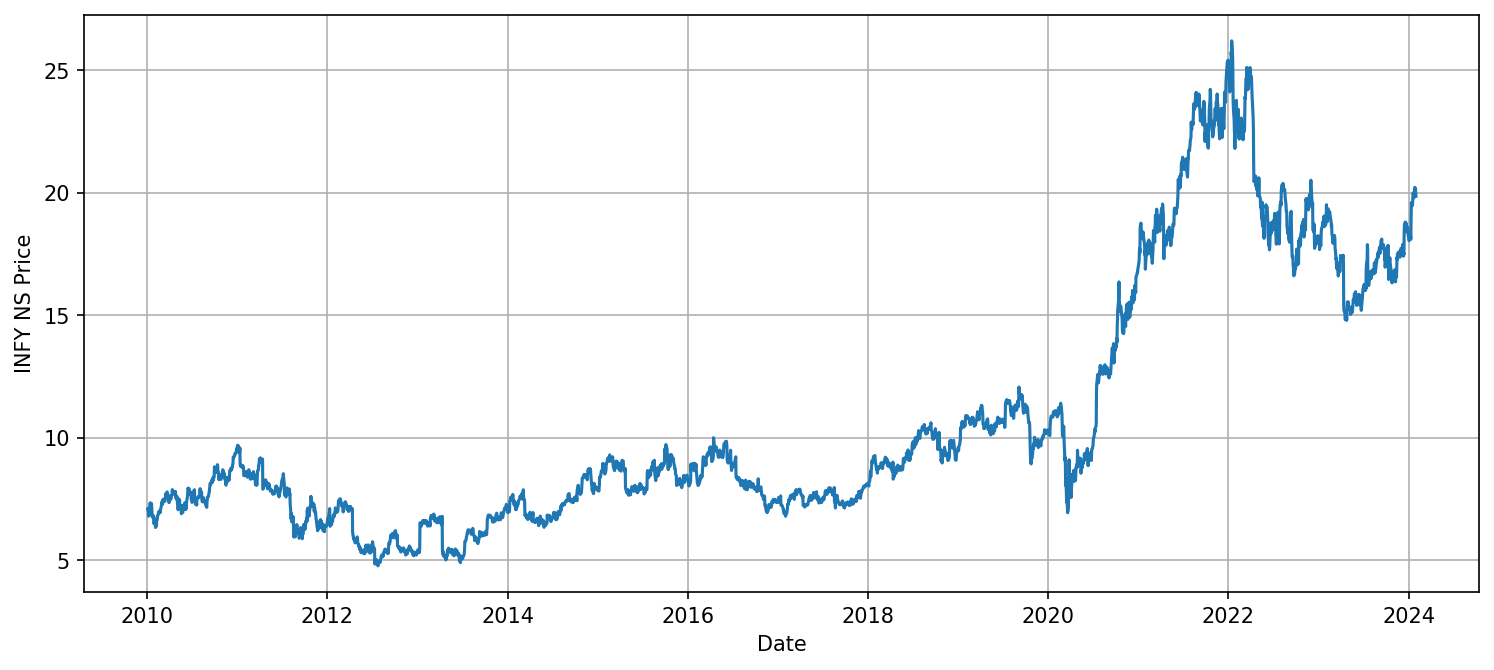

In [24]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
ax.plot(infy_df.index, infy_df['close']);
ax.set_xlabel('Date')
ax.set_ylabel('INFY NS Price')
ax.grid()
plt.savefig('1_overview', dpi=300)
upload_to_aws_png('1_overview')

In [25]:
split_size = int(0.8 * len(infy_df)) 

X_train, y_train = infy_df.index[:split_size], infy_df.close[:split_size]

X_test, y_test = infy_df.index[split_size:], infy_df.close[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2834, 709, 2834, 709)

File /Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/images/2_train_test_split.png has been uploaded to kosokolovsky-projects/projects/Stock_Price_analysis/plots/2_train_test_split.png


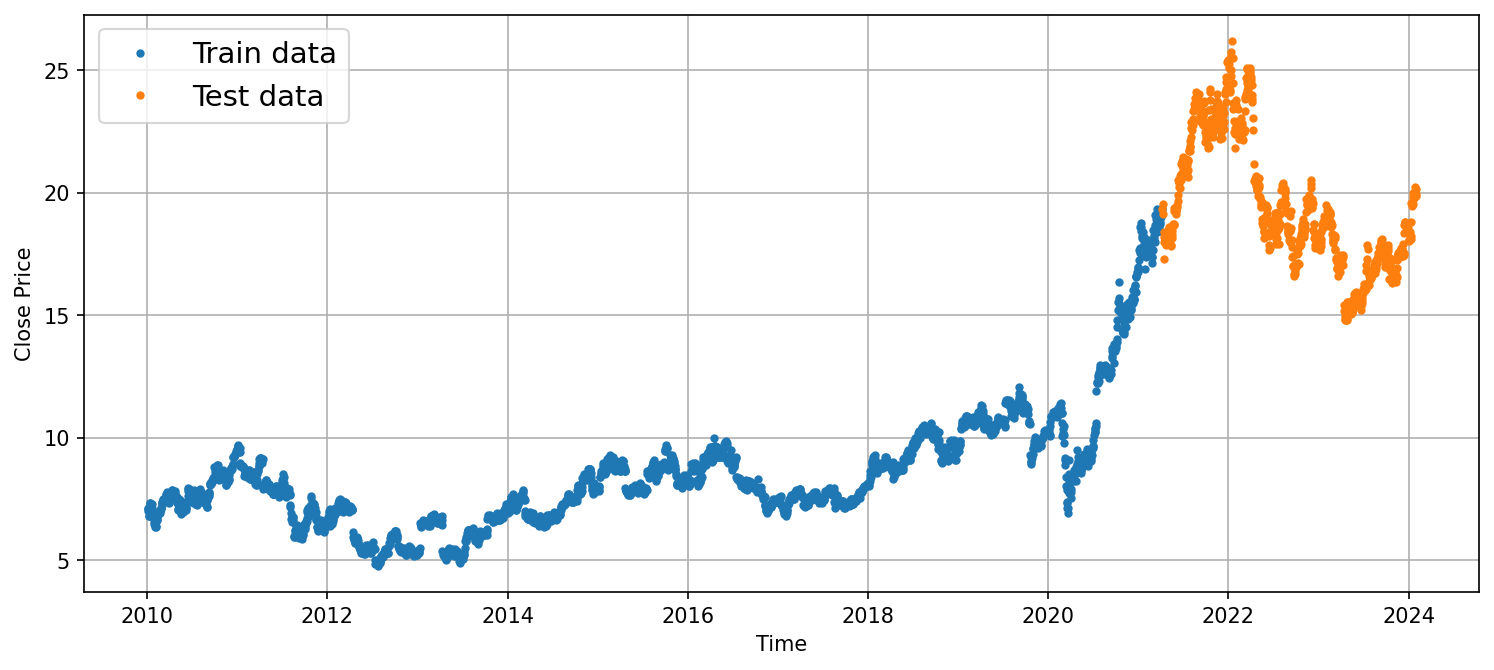

In [26]:
plot_name = '2_train_test_split'
plt.figure(figsize=(12, 5), dpi=150)
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

upload_to_aws_png(plot_name)

## Modeling

### Model 1: Dense

In [27]:
WINDOW_SIZE = 7
HORIZON = 1

In [28]:
full_windows, full_labels = make_windows_pandas(infy_df, labels=['close'], features=['close'], window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3536, 3536)

In [29]:
upload_csv(full_windows.head(10), 'window_7_without_features', index=True)
full_windows

File /Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/csv/window_7_without_features.csv has been uploaded to kosokolovsky-projects/projects/Stock_Price_analysis/csv/window_7_without_features.csv


,close,close_1,close_2,close_3,close_4,close_5,close_6
Date,,,,,,,
2010-01-13,7.095000,7.122500,7.013750,6.800000,6.817500,6.853750,7.206250
2010-01-14,7.122500,7.013750,6.800000,6.817500,6.853750,7.206250,7.320000
2010-01-15,7.013750,6.800000,6.817500,6.853750,7.206250,7.320000,7.343750
2010-01-16,6.800000,6.817500,6.853750,7.206250,7.320000,7.343750,7.242500
2010-01-17,6.817500,6.853750,7.206250,7.320000,7.343750,7.242500,7.315000
...,...,...,...,...,...,...,...
2024-01-25,19.469999,19.540001,19.830000,19.990000,19.870001,19.790001,19.990000
2024-01-26,19.540001,19.830000,19.990000,19.870001,19.790001,19.990000,20.090000
2024-01-27,19.830000,19.990000,19.870001,19.790001,19.990000,20.090000,20.219999


In [30]:
upload_csv(full_labels.head(10), 'label_without_features', index=True)
full_labels

File /Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/csv/label_without_features.csv has been uploaded to kosokolovsky-projects/projects/Stock_Price_analysis/csv/label_without_features.csv


,close
Date,
2010-01-13,7.320000
2010-01-14,7.343750
2010-01-15,7.242500
2010-01-16,7.315000
2010-01-17,7.137500
...,...
2024-01-25,20.090000
2024-01-26,20.219999
2024-01-27,20.170000


In [31]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2828, 708, 2828, 708)

In [32]:
tf.random.set_seed(42)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_1 = tf.keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(HORIZON, activation="linear")                   
], name="model_1_dense") 

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["mae"]) 

history_1 = model_1.fit(x=train_windows,
            y=train_labels, 
            epochs=200,
            verbose=1,
            batch_size=8,
            validation_data=(test_windows, test_labels), 
            callbacks=[callback],
            ) 


Epoch 1/200
354/354 [==============================] - 0s 617us/step - loss: 3.1480 - mae: 3.1480 - val_loss: 0.4131 - val_mae: 0.4131
Epoch 2/200
354/354 [==============================] - 0s 457us/step - loss: 0.1731 - mae: 0.1731 - val_loss: 0.4023 - val_mae: 0.4023
Epoch 3/200
354/354 [==============================] - 0s 486us/step - loss: 0.1701 - mae: 0.1701 - val_loss: 0.3957 - val_mae: 0.3957
Epoch 4/200
354/354 [==============================] - 0s 454us/step - loss: 0.1682 - mae: 0.1682 - val_loss: 0.4130 - val_mae: 0.4130
Epoch 5/200
354/354 [==============================] - 0s 449us/step - loss: 0.1679 - mae: 0.1679 - val_loss: 0.3882 - val_mae: 0.3882
Epoch 6/200
354/354 [==============================] - 0s 542us/step - loss: 0.1667 - mae: 0.1667 - val_loss: 0.4031 - val_mae: 0.4031
Epoch 7/200
354/354 [==============================] - 0s 454us/step - loss: 0.1647 - mae: 0.1647 - val_loss: 0.3857 - val_mae: 0.3857
Epoch 8/200
354/354 [==============================] - 

In [ ]:
plot_name = '3_plot_loss_model_1'

plot_loss_curves(history_1, metrics='mae')


upload(plot_name)

In [ ]:
model_1_train_preds = make_preds(model_1, train_windows)
model_1_test_preds = make_preds(model_1, test_windows)

In [ ]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), 
                                 y_pred=model_1_test_preds)
model_1_results

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train[-len(train_windows):], values=train_labels, start=0, label="train_data")
plot_time_series(timesteps=X_train[-len(train_windows):], values=model_1_train_preds, start=0, format="-", label="model_1_train")
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels, start=0, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_test_preds, start=0, format="-", label="model_1_test")

upload('4_preds_true_model_1')

### Model 2: Conv1D

In [33]:
HORIZON = 1 
WINDOW_SIZE = 7

In [34]:
full_windows, full_labels = make_windows_pandas(infy_df, labels=['close'], features=['close'], window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3536, 3536)

In [35]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2828, 708, 2828, 708)

In [43]:
tf.random.set_seed(42)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

model_2 = tf.keras.Sequential([
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), 
  layers.Conv1D(filters=64, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_conv1D")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

history_2 = model_2.fit(train_windows,
            train_labels,
            batch_size=64, 
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[callback])

Epoch 1/100
45/45 [==============================] - 0s 3ms/step - loss: 4.7602 - mae: 4.7602 - val_loss: 1.5160 - val_mae: 1.5160
Epoch 2/100
45/45 [==============================] - 0s 913us/step - loss: 0.3123 - mae: 0.3123 - val_loss: 0.4145 - val_mae: 0.4145
Epoch 3/100
45/45 [==============================] - 0s 875us/step - loss: 0.1838 - mae: 0.1838 - val_loss: 0.4620 - val_mae: 0.4620
Epoch 4/100
45/45 [==============================] - 0s 922us/step - loss: 0.1801 - mae: 0.1801 - val_loss: 0.4462 - val_mae: 0.4462
Epoch 5/100
45/45 [==============================] - 0s 967us/step - loss: 0.1786 - mae: 0.1786 - val_loss: 0.4259 - val_mae: 0.4259
Epoch 6/100
45/45 [==============================] - 0s 959us/step - loss: 0.1767 - mae: 0.1767 - val_loss: 0.4278 - val_mae: 0.4278
Epoch 7/100
45/45 [==============================] - 0s 1ms/step - loss: 0.1756 - mae: 0.1756 - val_loss: 0.4060 - val_mae: 0.4060
Epoch 8/100
45/45 [==============================] - 0s 958us/step - loss

File /Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/images/plot_loss_model_2.png has been uploaded to kosokolovsky-projects/projects/Stock_Price_analysis/plots/plot_loss_model_2.png


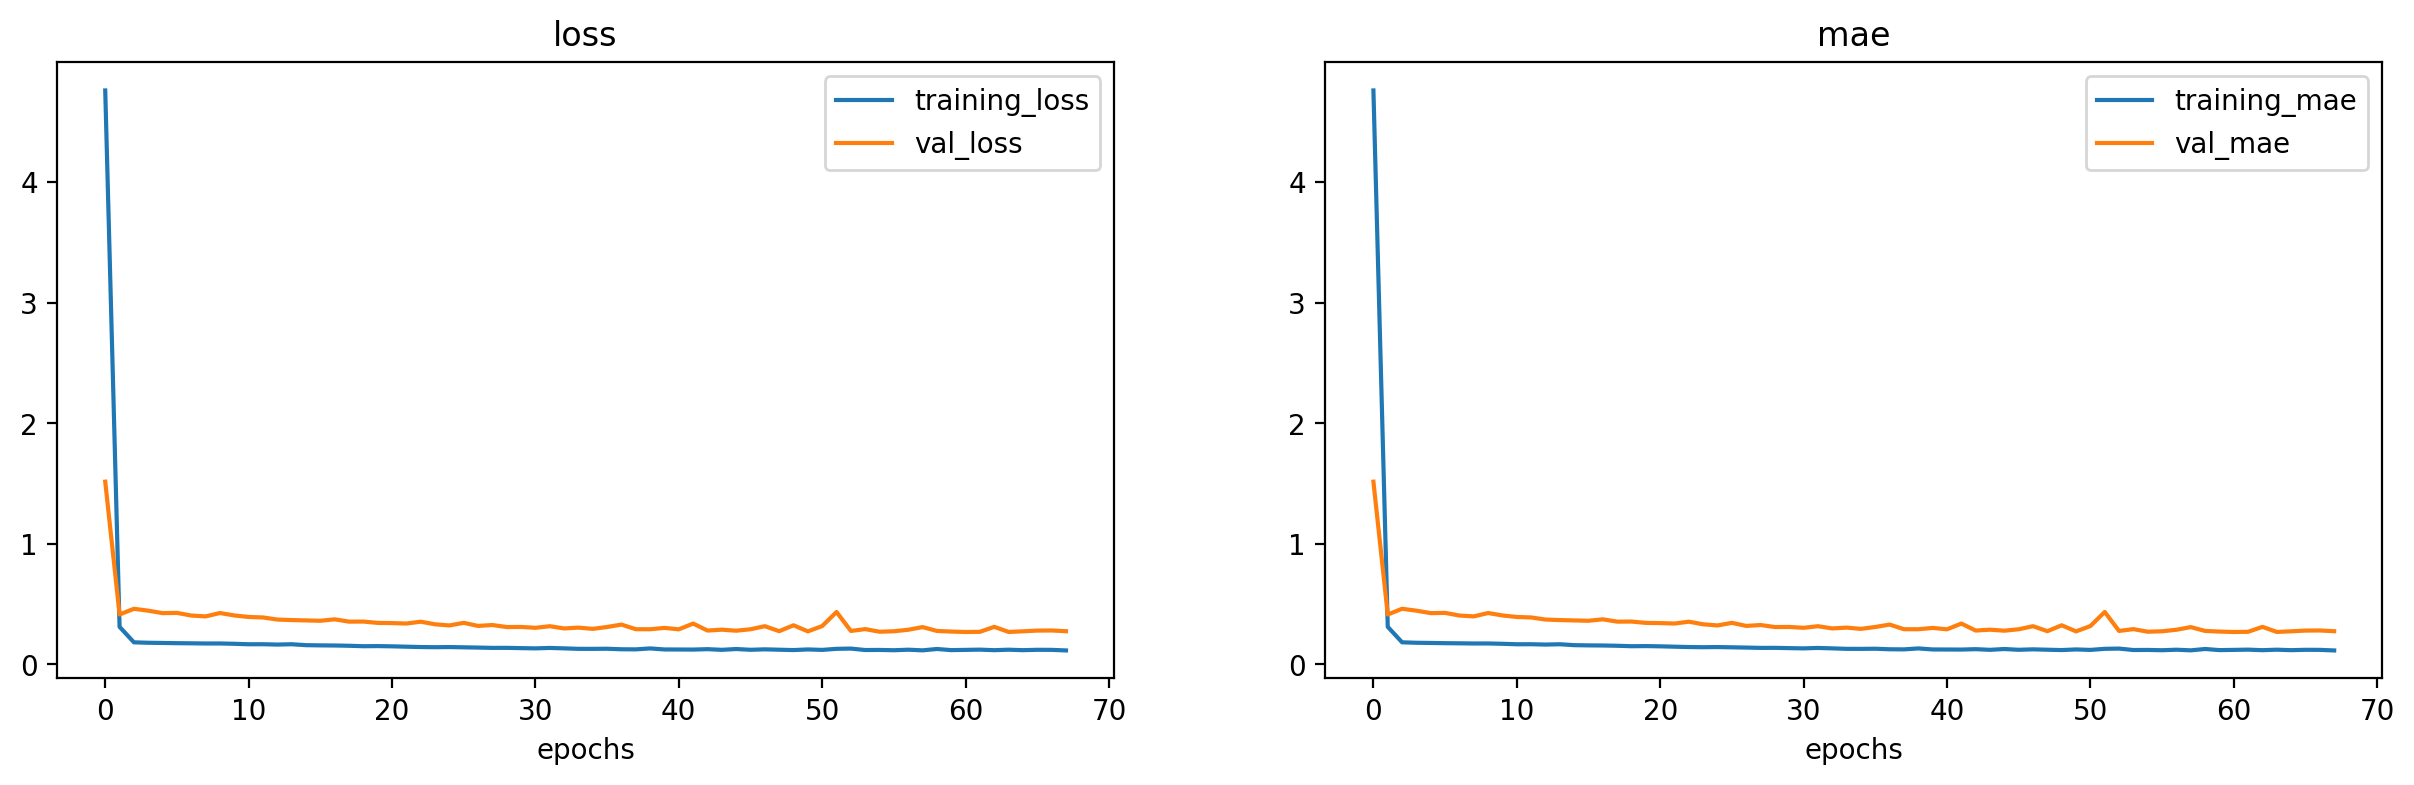

In [44]:
plot_name = 'plot_loss_model_2'

plot_loss_curves(history_2, metrics='mae')


upload(plot_name)

In [45]:
model_2_train_preds = make_preds(model_2, train_windows)
model_2_test_preds = make_preds(model_2, test_windows)

23/23 [==============================] - 0s 353us/step


In [46]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), 
                                 y_pred=model_2_test_preds)
model_2_results

{'mae': 0.26939878, 'mse': 0.13743562, 'rmse': 0.3707231, 'mape': 1.3736644}

File /Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/images/preds_true_model_2.png has been uploaded to kosokolovsky-projects/projects/Stock_Price_analysis/plots/preds_true_model_2.png


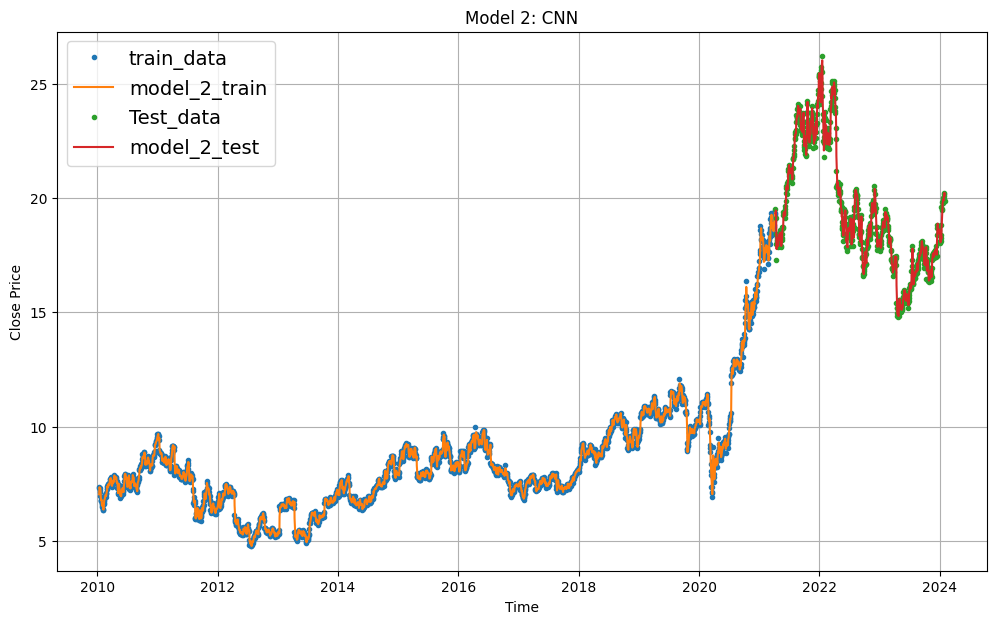

In [47]:
plt.figure(figsize=(12, 7))
plt.title('Model 2: CNN')
plot_time_series(timesteps=X_train[-len(train_windows):], values=train_labels, start=0, label="train_data")
plot_time_series(timesteps=X_train[-len(train_windows):], values=model_2_train_preds, start=0, format="-", label="model_2_train")
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels, start=0, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_test_preds, start=0, format="-", label="model_2_test")

upload('preds_true_model_2')

### Model 3: Machine Learning

In [65]:
regression_models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'XGBoost': XGBRegressor(n_estimators=1_000, max_depth=2, eta=1),
}

In [66]:
def make_regression(x_train, y_train, x_test, y_test, model, model_name, verbose=True):

    model.fit(x_train, y_train)

    y_predict = model.predict(x_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)

    y_predict = model.predict(x_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False
    )

    y_predict = model.predict(x_train)
    r2 = r2_score(y_train, y_predict)

    if verbose:
        print(f"----Model name = {model_name}-----")
        print(f"Train error = {train_error}")
        print(f"Test error = {test_error}")
        print(f"r2_score = {r2}")
        print("--------------------------------")

    trained_model = model

    return trained_model, y_predict, train_error, test_error, r2

In [67]:
pred_dict = {
    'model': [],
    'regression_model': [],
    'Train Error': [],
    'Test Error': [],
    'R2': []
}


In [68]:
for model_name in regression_models.keys():

        trained_model, y_predict, train_error, test_error, r2 = make_regression(train_windows, np.ravel(train_labels), test_windows, np.ravel(test_labels), regression_models[model_name], model_name=model_name, verbose=True)

        pred_dict['model'].append(trained_model)
        pred_dict["regression_model"].append(model_name)
        pred_dict["Train Error"].append(train_error)
        pred_dict["Test Error"].append(test_error)
        pred_dict["R2"].append(r2)

----Model name = Ridge-----
Train error = 0.1620938831180824
Test error = 0.33792938267823824
r2_score = 0.9956398870342021
--------------------------------
----Model name = Lasso-----
Train error = 0.43994713481695846
Test error = 1.8950188401766592
r2_score = 0.9678807440495939
--------------------------------
----Model name = XGBoost-----
Train error = 0.05535120169334919
Test error = 2.576490332457687
r2_score = 0.999491584717189
--------------------------------


In [79]:
res_model_3_without = pd.DataFrame(pred_dict)
res_model_3_without = res_model_3_without[[col for col in test_without.columns if col != 'model']]
res_model_3_without.set_index('regression_model', inplace=True)
upload_csv(res_model_3_without, 'res_ML_without_features', index=True)

File /Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/csv/res_ML_without_features.csv has been uploaded to kosokolovsky-projects/projects/Stock_Price_analysis/csv/res_ML_without_features.csv


In [78]:
res_model_3_without

,Train Error,Test Error,R2
regression_model,,,
Ridge,0.162094,0.337929,0.995640
Lasso,0.439947,1.895019,0.967881
XGBoost,0.055351,2.576490,0.999492


File /Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/images/xgboost_feature_importance_without.png has been uploaded to kosokolovsky-projects/projects/Stock_Price_analysis/plots/xgboost_feature_importance_without.png


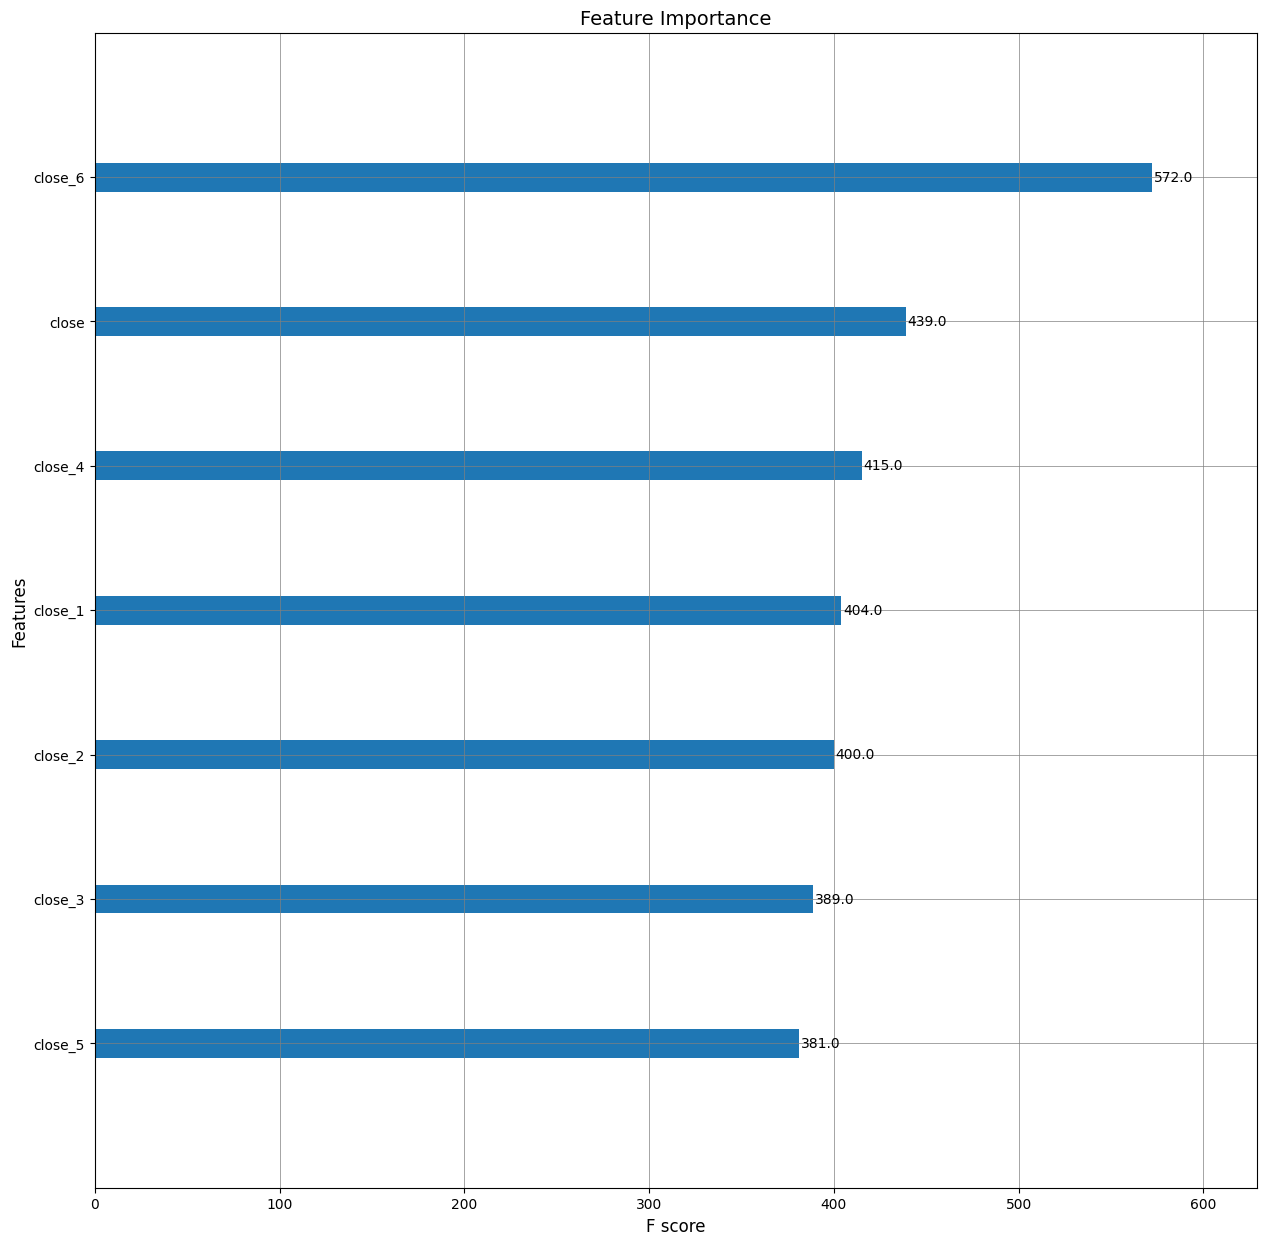

In [81]:
model = pred_dict['model'][2]

fig, ax = plt.subplots(figsize=(15, 15)) 
xgboost.plot_importance(model, ax=ax)
ax.set_title('Feature Importance', fontsize=14) 
ax.set_xlabel('F score', fontsize=12)
ax.set_ylabel('Features', fontsize=12)  
ax.grid('on', which='major', linestyle='-', linewidth='0.5', color='gray') 
ax.tick_params(axis='both', which='major', labelsize=10)

upload('xgboost_feature_importance_without')

## Add Features

- Create the following dummy time series: 
    
    - 3.1 Volume shocks - If volume traded is 10% higher/lower than the previous day - make a 0/1 boolean time series for shock, 0/1 dummy-coded time series for the direction of shock. 
    
    - 3.2 Price shocks - If the closing price at T vs T+1 has a difference > 2%, then 0/1 boolean time series for shock, 0/1 dummy-coded time series for the direction of shock. 
    
    - 3.3 Pricing black swan - If the closing price at T vs T+1 has a difference > 2%, then 0/1 boolean time series for shock, 0/1 dummy-coded time series for the direction of shock. 
    
    - 3.4 Pricing shock without volume shock - based on points 3.1 & 3.2 - Make a 0/1 dummy time series.

In [85]:
infy_df_features = infy_df.copy()
infy_df_added_features = add_features_to_df(infy_df_features)
infy_df_added_features

,close,volume_shock_yes_no,volume_shock_direction,price_shock_yes_no,price_shock_direction,scaled_volume
Date,,,,,,
2010-01-04,7.095000,0,0,0,0,0.070807
2010-01-05,7.122500,0,0,0,1,0.048547
2010-01-06,7.013750,1,1,0,0,0.073389
2010-01-07,6.800000,1,1,0,0,0.131761
2010-01-08,6.817500,0,0,0,1,0.071544
...,...,...,...,...,...,...
2024-01-25,20.090000,0,0,0,1,0.042465
2024-01-26,20.219999,0,0,0,1,0.031585
2024-01-29,20.170000,0,0,0,0,0.028770


In [86]:
upload_csv(infy_df_added_features.head(10), 'window_7_with_features', index=True)

File /Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/csv/window_7_with_features.csv has been uploaded to kosokolovsky-projects/projects/Stock_Price_analysis/csv/window_7_with_features.csv


### Model 4: Dense

In [87]:
infy_df_added_features

,close,volume_shock_yes_no,volume_shock_direction,price_shock_yes_no,price_shock_direction,scaled_volume
Date,,,,,,
2010-01-04,7.095000,0,0,0,0,0.070807
2010-01-05,7.122500,0,0,0,1,0.048547
2010-01-06,7.013750,1,1,0,0,0.073389
2010-01-07,6.800000,1,1,0,0,0.131761
2010-01-08,6.817500,0,0,0,1,0.071544
...,...,...,...,...,...,...
2024-01-25,20.090000,0,0,0,1,0.042465
2024-01-26,20.219999,0,0,0,1,0.031585
2024-01-29,20.170000,0,0,0,0,0.028770


In [88]:
full_windows_with_features, full_labels_with_features = make_windows_pandas(infy_df_added_features, labels=['close'], features=list(infy_df_added_features.columns), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows_with_features), len(full_labels_with_features)

(3536, 3536)

In [89]:
train_windows_feat, test_windows_feat, train_labels_feat, test_labels_feat = make_train_test_splits(full_windows_with_features, full_labels_with_features, test_split=.2)
train_windows_feat.shape, test_windows_feat.shape, train_labels_feat.shape, test_labels_feat.shape

((2828, 47), (708, 47), (2828, 1), (708, 1))

In [90]:
tf.random.set_seed(42)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model_4 = tf.keras.Sequential([
  layers.Flatten(),
  layers.Dense(64, activation="relu"),
  layers.Dense(HORIZON, activation="linear")                   
], name="model_4_dense") 

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["mae"]) 

history_4 = model_4.fit(x=train_windows_feat,
            y=train_labels_feat, 
            epochs=200,
            verbose=1,
            batch_size=8,
            validation_data=(test_windows_feat, test_labels_feat), 
            callbacks=[callback],
            ) 


Epoch 1/200
354/354 [==============================] - 0s 714us/step - loss: 1.5473 - mae: 1.5473 - val_loss: 0.9578 - val_mae: 0.9578
Epoch 2/200
354/354 [==============================] - 0s 482us/step - loss: 0.2176 - mae: 0.2176 - val_loss: 0.5024 - val_mae: 0.5024
Epoch 3/200
354/354 [==============================] - 0s 485us/step - loss: 0.1665 - mae: 0.1665 - val_loss: 0.4183 - val_mae: 0.4183
Epoch 4/200
354/354 [==============================] - 0s 481us/step - loss: 0.1495 - mae: 0.1495 - val_loss: 0.3900 - val_mae: 0.3900
Epoch 5/200
354/354 [==============================] - 0s 480us/step - loss: 0.1393 - mae: 0.1393 - val_loss: 0.3195 - val_mae: 0.3195
Epoch 6/200
354/354 [==============================] - 0s 490us/step - loss: 0.1347 - mae: 0.1347 - val_loss: 0.3212 - val_mae: 0.3212
Epoch 7/200
354/354 [==============================] - 0s 661us/step - loss: 0.1310 - mae: 0.1310 - val_loss: 0.3204 - val_mae: 0.3204
Epoch 8/200
354/354 [==============================] - 

File /Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/images/plot_loss_model_4.png has been uploaded to kosokolovsky-projects/projects/Stock_Price_analysis/plots/plot_loss_model_4.png


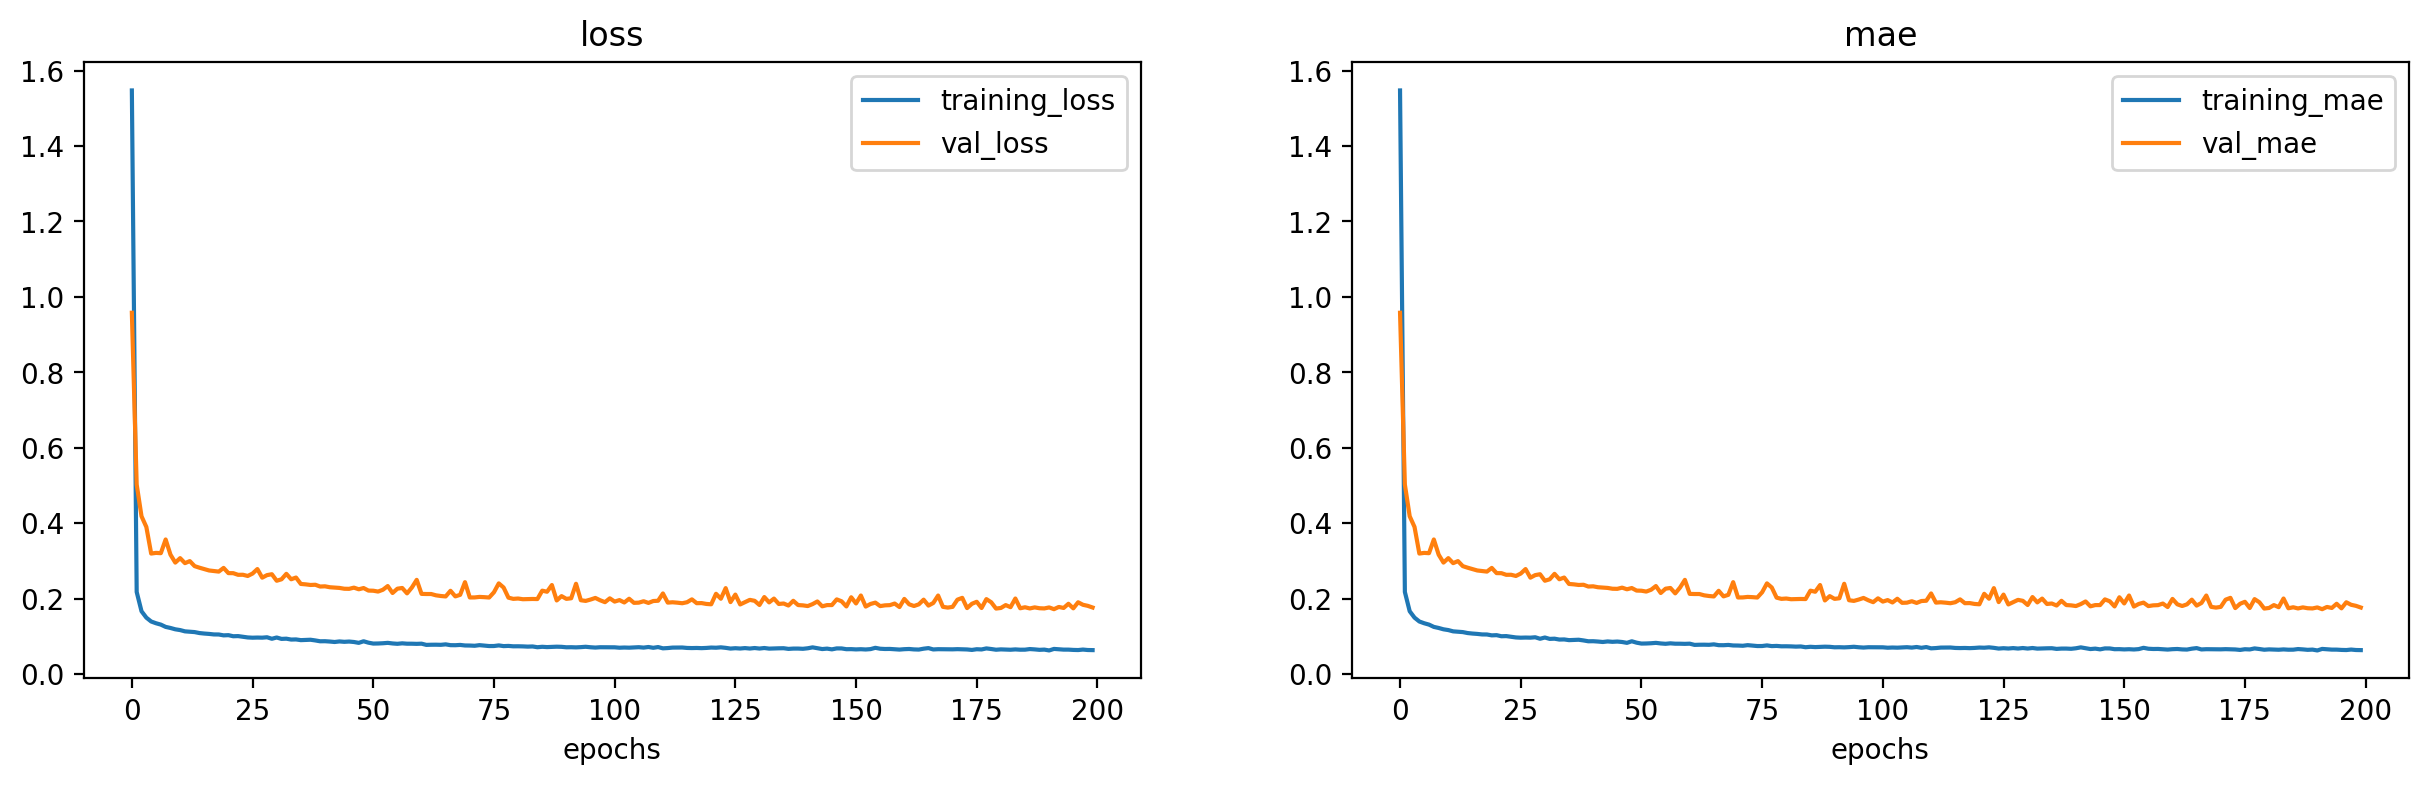

In [92]:
plot_loss_curves(history_4, metrics='mae')

upload('plot_loss_model_4')

In [94]:
model_4_train_preds = make_preds(model_4, train_windows_feat)
model_4_test_preds = make_preds(model_4, test_windows_feat)

23/23 [==============================] - 0s 300us/step


In [95]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels_feat), 
                                 y_pred=model_4_test_preds)
model_4_results

{'mae': 0.176373, 'mse': 0.07096045, 'rmse': 0.26638404, 'mape': 0.8969198}

File /Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/images/preds_true_model_4.png has been uploaded to kosokolovsky-projects/projects/Stock_Price_analysis/plots/preds_true_model_4.png


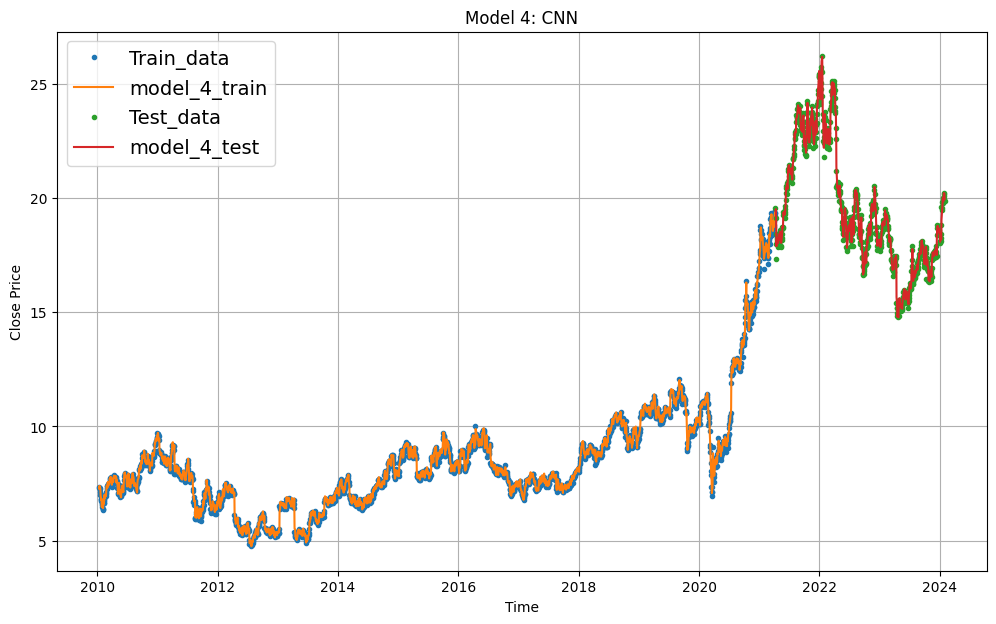

In [97]:
plt.figure(figsize=(12, 7))
plt.title('Model 4: CNN')
plot_time_series(timesteps=X_train[-len(train_windows):], values=train_labels, start=0, label="Train_data")
plot_time_series(timesteps=X_train[-len(train_windows):], values=model_4_train_preds, start=0, format="-", label="model_4_train")
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels, start=0, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_4_test_preds, start=0, format="-", label="model_4_test")

upload('preds_true_model_4')

### Model 5: Machine Learning

In [106]:
regression_models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'XGBoost': XGBRegressor(n_estimators=1_000, max_depth=3, min_child_weight=5),
}
def make_regression(x_train, y_train, x_test, y_test, model, model_name, verbose=True):

    model.fit(x_train, y_train)

    y_predict = model.predict(x_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)

    y_predict = model.predict(x_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False)

    y_predict = model.predict(x_train)
    r2 = r2_score(y_train, y_predict)

    if verbose:
        print(f"----Model name = {model_name}-----")
        print(f"Train error = {train_error}")
        print(f"Test error = {test_error}")
        print(f"r2_score = {r2}")
        print("--------------------------------")

    trained_model = model

    return trained_model, y_predict, train_error, test_error, r2

pred_dict = {
    'model': [],
    'regression_model': [],
    'Train Error': [],
    'Test Error': [],
    'R2': []
}
for model_name in regression_models.keys():

        trained_model, y_predict, train_error, test_error, r2 = make_regression(train_windows_feat, np.ravel(train_labels_feat), test_windows_feat, np.ravel(test_labels_feat), regression_models[model_name], model_name=model_name, verbose=True)

        pred_dict['model'].append(trained_model)
        pred_dict["regression_model"].append(model_name)
        pred_dict["Train Error"].append(train_error)
        pred_dict["Test Error"].append(test_error)
        pred_dict["R2"].append(r2)

----Model name = Ridge-----
Train error = 0.10192521736776995
Test error = 0.24495342558336636
r2_score = 0.9982760376320257
--------------------------------
----Model name = Lasso-----
Train error = 0.43994713481695846
Test error = 1.8950188401766592
r2_score = 0.9678807440495939
--------------------------------
----Model name = XGBoost-----
Train error = 0.011264663637257385
Test error = 2.345213229680965
r2_score = 0.9999789427843273
--------------------------------


In [107]:
res_model_5_with = pd.DataFrame(pred_dict)
res_model_5_with = res_model_5_with[[col for col in res_model_5_with.columns if col != 'model']]
res_model_5_with.set_index('regression_model', inplace=True)
upload_csv(res_model_5_with, 'res_ML_with_features', index=True)

File /Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/csv/res_ML_with_features.csv has been uploaded to kosokolovsky-projects/projects/Stock_Price_analysis/csv/res_ML_with_features.csv


File /Users/konstantinsokolovskiy/Desktop/My_Big_Project/projects/my_projects/Example_Pyspark/data/images/xgboost_feature_importance_with.png has been uploaded to kosokolovsky-projects/projects/Stock_Price_analysis/plots/xgboost_feature_importance_with.png


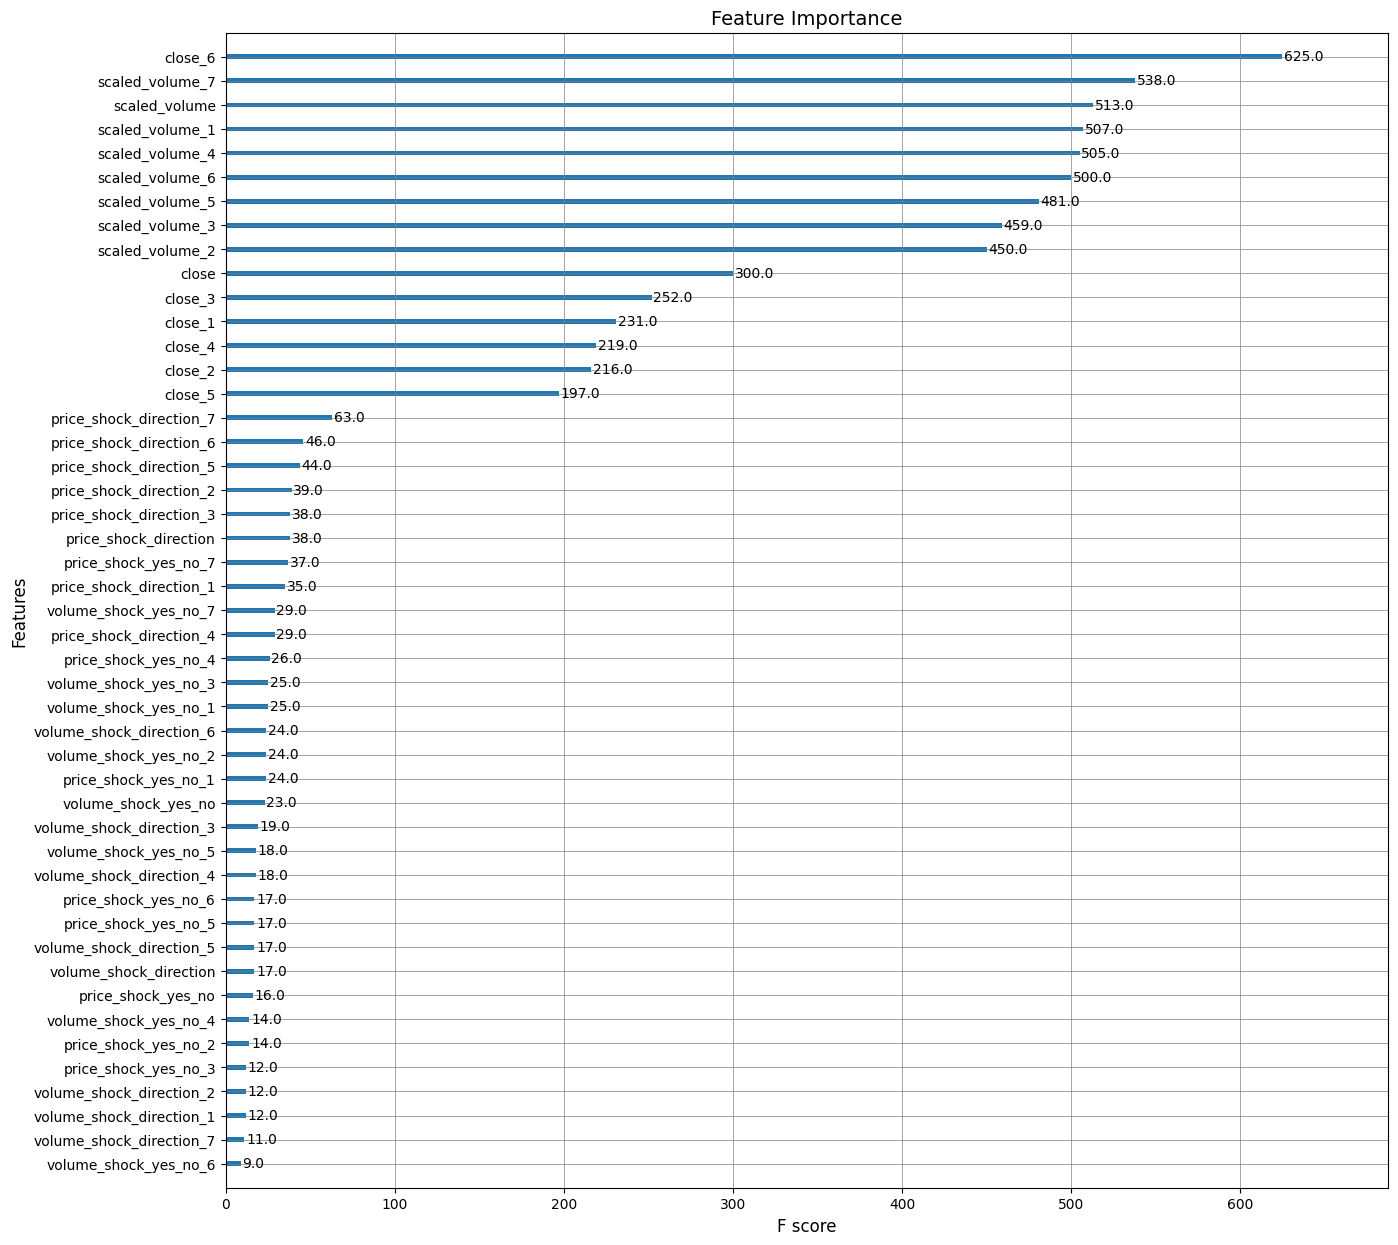

In [100]:
model = pred_dict['model'][2]

fig, ax = plt.subplots(figsize=(15, 15)) 
xgboost.plot_importance(model, ax=ax)
ax.set_title('Feature Importance', fontsize=14) 
ax.set_xlabel('F score', fontsize=12)
ax.set_ylabel('Features', fontsize=12)  
ax.grid('on', which='major', linestyle='-', linewidth='0.5', color='gray') 
ax.tick_params(axis='both', which='major', labelsize=10)

upload('xgboost_feature_importance_with')

## Results

In [ ]:
model_1_results
model_2_results
model_5_results

pd.DataFrame([model_1_results, model_2_results, model_5_results], index=['Dense_1', 'Conv_1', 'Dense_2'])

In [ ]:
model_1_results

In [ ]:
df = pd.DataFrame()
d = {}
for key, value in pred_dict.items():
    if key != 'model':
        print(key, value)
        d[key] = value

In [ ]:
test = pd.DataFrame(pred_dict)
test[[col for col in test.columns if col != 'model']]

In [ ]:
upload_csv(test, 'ML_with_features', index=True)

In [ ]:
evaluate_preds()